In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(18,6)})
pd.set_option('display.max_columns', None)

In [2]:
DF_fut_long = pd.read_csv("E:\\Academic\\DATA & INSIGHTS\\Wheat Prices Forecasting\\stage_data\\fut_long.csv")
DF_fut_long['time'] = pd.to_datetime(DF_fut_long['time'])

## Preprocessing data for modelling

### Dealing with Outliers

Removing Outliers After checkingthe time series and confirming them <br>
Nulls are replaced by nans to be imputed later

In [3]:
for i in DF_fut_long['Wheat_ID'].unique():
    q75 = DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, 'price'].quantile(0.75)
    q25 = DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, 'price'].quantile(0.25)
    q50 = DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, 'price'].quantile(0.50)

    upper_bound = q50 + ((q75 - q25) * 2.5)
    lower_bound = q50 - ((q75 - q25) * 2.5)
                                                                            
    outliers = ((DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, 'price'] > upper_bound) | (DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, 'price'] < lower_bound))                                                                     
    print("Number of otliers removed in " + i , outliers.sum())
    DF_fut_long.loc[(DF_fut_long['Wheat_ID'] == i) & outliers, 'price'] = np.nan

Number of otliers removed in 1Wc1 0
Number of otliers removed in 1KWc1 0
Number of otliers removed in MWEc1 0
Number of otliers removed in CPMc1 0
Number of otliers removed in CWHc1 0
Number of otliers removed in YWMc1 0
Number of otliers removed in YWKc1 0
Number of otliers removed in MWBWX 123
Number of otliers removed in MWBc1 101
Number of otliers removed in BL2c1 0
Number of otliers removed in AGRc1 2
Number of otliers removed in WEAc1 73
Number of otliers removed in NWTc1 0
Number of otliers removed in LWBc1 0
Number of otliers removed in BWFc1 0


### Imputing nulls

In [4]:
DF_fut_long = DF_fut_long.set_index('time')

In [7]:
DF_fut_long.pivot(columns="Wheat_ID", values="price").count()

Wheat_ID
1KWc1    2738
1Wc1     2740
AGRc1    1977
BL2c1    2781
BWFc1     699
CPMc1    2145
CWHc1    2023
LWBc1    2752
MWBWX    2518
MWBc1    2256
MWEc1    2735
NWTc1    2706
WEAc1    2641
YWKc1    2768
YWMc1    1307
dtype: int64

<AxesSubplot:xlabel='Wheat_ID', ylabel='time'>

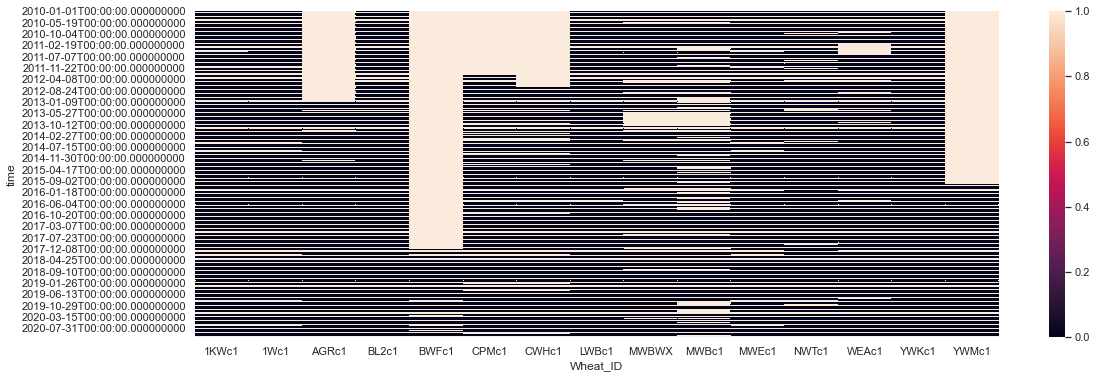

In [5]:
sns.heatmap(DF_fut_long.pivot(columns="Wheat_ID", values="price").isna())

In [8]:
col_hinull = ['BWFc1', 'MWBc1']

In [10]:
for i in [i for i in DF_fut_long['Wheat_ID'].unique() if i not in col_hinull]:
    DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i,
                     'price'] = DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i,
                                                 'price'].interpolate(
                                                     method='time', limit_area = 'inside')

<AxesSubplot:xlabel='Wheat_ID', ylabel='time'>

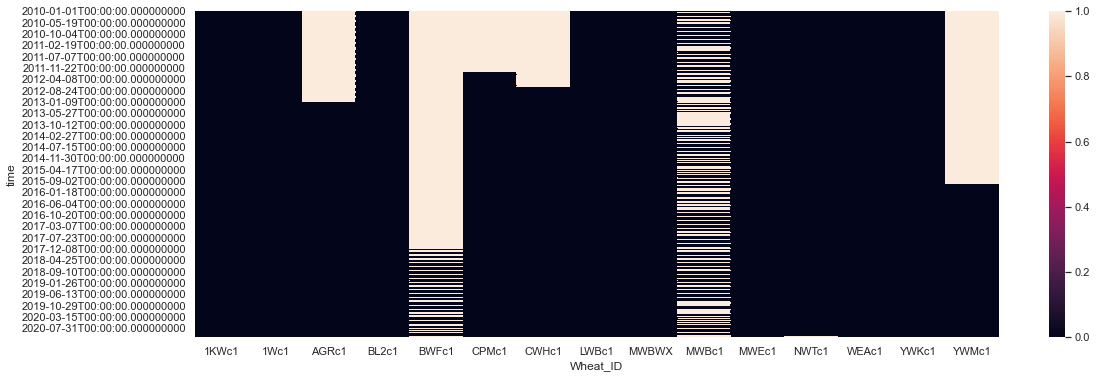

In [11]:
sns.heatmap(DF_fut_long.pivot(columns="Wheat_ID", values="price").isna())

In [12]:
DF_fut_long = DF_fut_long[~DF_fut_long['Wheat_ID'].isin(col_hinull)].dropna()

In [13]:
DF_fut_long.isna().sum()

Unnamed: 0    0
Wheat_ID      0
price         0
dtype: int64

In [14]:
DF_fut_long.reset_index().groupby('Wheat_ID').agg({'time': ['min', 'max','count']}).assign(delta=lambda x: x['time']['max'] - x['time']['min'])

time                      delta
                min        max count          
Wheat_ID                                      
1KWc1    2010-01-07 2020-11-17  3968 3967 days
1Wc1     2010-01-07 2020-11-17  3968 3967 days
AGRc1    2013-01-22 2020-11-16  2856 2855 days
BL2c1    2010-01-07 2020-11-16  3967 3966 days
CPMc1    2012-01-17 2020-11-16  3227 3226 days
CWHc1    2012-07-24 2020-11-17  3039 3038 days
LWBc1    2010-01-07 2020-11-16  3967 3966 days
MWBWX    2010-01-07 2020-11-16  3967 3966 days
MWEc1    2010-01-07 2020-11-17  3968 3967 days
NWTc1    2010-01-07 2020-11-13  3964 3963 days
WEAc1    2010-01-07 2020-11-16  3967 3966 days
YWKc1    2010-01-07 2020-11-17  3968 3967 days
YWMc1    2015-10-12 2020-11-17  1864 1863 days

Preprocessing Summary:
- We have removed outliers using a more tolerent threshold after visualising to prevent losing any real data.
- We have filled Nulls accordingly:
    - in low nulls, time serieses with linear interpolation using time
    - in non clustered high nulls, will be dropped for now from analysis
- We have made sure that data is now having a proper time step and that all steps values exist

In [16]:
# DF_fut_long.to_csv('E:\\Academic\\DATA & INSIGHTS\\Wheat Prices Forecasting\\stage_data\\fut_long_preprocessed.csv')